In [1]:
# Sagar Sahu
# IBM Quantum Challenge 2024- Lab 2

!pip install qiskit[visualization]==1.0.2
!pip install qiskit_ibm_runtime
!pip install qiskit_aer
!pip install qiskit-transpiler-service
!pip install graphviz

from qiskit.circuit.random import random_circuit
from qiskit.circuit.library import XGate, YGate
from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeOsaka
from qiskit.transpiler import InstructionProperties, PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.plugin import list_stage_plugins
from qiskit.transpiler.timing_constraints import TimingConstraints
from qiskit.transpiler.passes.scheduling import ASAPScheduleAnalysis,PadDynamicalDecoupling
from qiskit.visualization.timeline import draw, IQXStandard
from qiskit.transpiler import StagedPassManager
from qiskit.visualization import plot_circuit_layout
import matplotlib.pyplot as plt
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 5.0 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=6e6d6207ede9dd97e53363a9ff8c866a4105445588128f1887dc272843de67de
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.7/322.7 kB 7.8 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - 

In [2]:
import numpy as np
from qiskit import transpile, QuantumCircuit

# Cost function to calculate the fidelity of a circuit
def transpile_scoring(circ, layout, backend):
    fid = 1
    touched = set()
    dt = backend.dt
    num_qubits = backend.num_qubits

    error=0
    
    t1s = [backend.qubit_properties(qq).t1 for qq in range(num_qubits)]
    t2s = [backend.qubit_properties(qq).t2 for qq in range(num_qubits)]

    
    for item in circ._data:
        for gate in backend.operation_names:
            if item[0].name == gate:
                if (item[0].name == 'cz') or (item[0].name == 'ecr'):
                    q0 = circ.find_bit(item[1][0]).index
                    q1 = circ.find_bit(item[1][1]).index
                    fid *= 1 - backend.target[item[0].name][(q0, q1)].error
                    touched.add(q0)
                    touched.add(q1)
                elif item[0].name == 'measure':
                    q0 = circ.find_bit(item[1][0]).index
                    fid *= 1 - backend.target[item[0].name][(q0, )].error
                    touched.add(q0)
    
                elif item[0].name == 'delay':
                    q0 = circ.find_bit(item[1][0]).index
                    # Ignore delays that occur before gates
                    # This assumes you are in ground state and errors
                    # do not occur.
                    if q0 in touched:
                        time = item[0].duration * dt
                        fid *= 1-qubit_error(time, t1s[q0], t2s[q0])
                else:
                    q0 = circ.find_bit(item[1][0]).index
                    fid *= 1 - backend.target[item[0].name][(q0, )].error
                    touched.add(q0)
    return fid

def qubit_error(time, t1, t2):
    """Compute the approx. idle error from T1 and T2
    Parameters:
        time (float): Delay time in sec
        t1 (float): T1 time in sec
        t2 (float): T2 time in sec
    Returns:
        float: Idle error
    """
    t2 = min(t1, t2)
    rate1 = 1/t1
    rate2 = 1/t2
    p_reset = 1-np.exp(-time*rate1)
    p_z = (1-p_reset)*(1-np.exp(-time*(rate2-rate1)))/2
    return p_z + p_reset

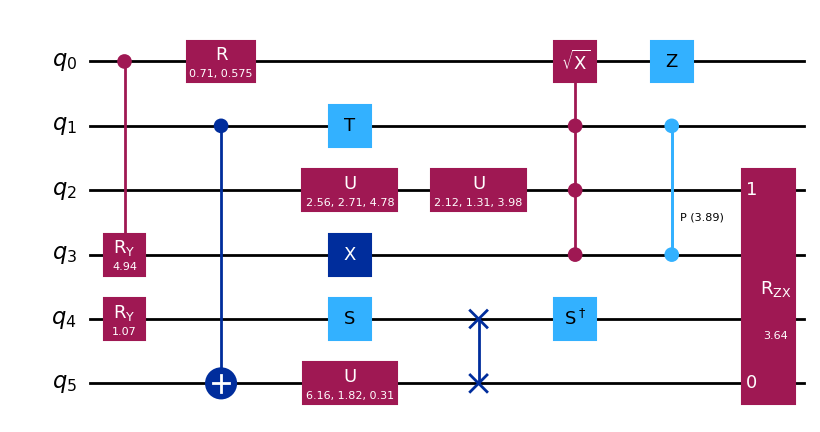

In [3]:
# Preset pass manager stages for transpilation:
# 1. init- this stage is used to translate any gates that operate on more than two qubits, into gates that only operate on one or two qubits
# 2. routing- This stage inserts the appropriate number of SWAP gates in order to execute the circuits using the selected layout
# 3. layout- This stage executes a sequence of gates, a one-to-one mapping from the "virtual" qubits to the "physical" qubits in an actual quantum device
# 4. translation- This stage translates (or unrolls) the gates specified in a circuit to the native basis gates of a specified backend
# 5. optimization- this stage centers around reducing the number of circuit operations and the depth of circuits with several optimization options
# 6. scheduling- this pass can be thought of as explicitly inserting hardware-aware operations like delay instructions to account for the idle time between gate executions

# generate_preset_pass_manager takes 1 arg, optim. level which is an int either 0, 1, 2, 3

# Scoring function that maeasures perfoemance of the transpiled circuit
# receives the transpiled circuit, its final layout, and its target backend as inputs, returning a score (closer to 0 is better)

def scoring (qc, backend):
    layout = qc._layout
    fidelity = transpile_scoring(qc, layout, backend)
    return 1 - fidelity

seed = 10000
num_qubits = 6
depth = 4
qc = random_circuit(num_qubits,depth,measure=False, seed=seed)
qc.draw('mpl')